In [1]:
import gc
import os

import pandas as pd
from gensim.models import Word2Vec
from IPython.display import display
from matplotlib import pyplot as plt
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score,
                             classification_report, confusion_matrix, f1_score)
from torch.utils.data import DataLoader
from tqdm.auto import tqdm, trange

from rnn_data import *
from rnn_models import *
from rnn_utils import *

In [2]:
TRAIN_PATH = 'data/NLP3/train.csv'
TEST_PATH = 'data/NLP3/test.csv'

random_seed = 42

all_labels = ['World',
              'Sports',
              'Business',
              'Sci/Tech',]

os.makedirs("checkpoints", exist_ok=True)
os.makedirs("results", exist_ok=True)

In [3]:
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

train["text"] = train["text"].apply(preprocess_text)
train["label"] = train["label"].apply(lambda x: int(x))
test["text"] = test["text"].apply(preprocess_text)
test["label"] = test["label"].apply(lambda x: int(x))

In [4]:
val_frac = 0.1

# break train into train and validation
train = train.sample(frac=1, random_state=random_seed)
train = train.reset_index(drop=True)
train_size = int((1 - val_frac) * len(train))
train_data = train[:train_size]
val_data = train[train_size:]

In [5]:
display(train_data.head())
display(val_data.head())
display(test.head())

,index,text,label
0,1860,"[spammers, embrace, email, authentication, spa...",3
1,353,"[ties, us, asia, stake, aussie, polls, sydney,...",0
2,1333,"[disclosed, credit, card, fees, say, banks, ma...",2
3,905,"[baseball, win, yankees, alex, rodriguez, scor...",1
4,1289,"[jo, ann, stores, threading, water, sales, fla...",2


,index,text,label
1800,1678,"[mobile, vendors, tie, mobile, tv, nokia, nec,...",3
1801,748,"[loeb, course, equal, win, milestone, world, c...",1
1802,1851,"[apple, expo, apple, intros, imac, g5, maccent...",3
1803,1430,"[fool, look, ahead, motley, fool, rick, munarr...",2
1804,484,"[sudan, peace, deal, must, tackle, past, abuse...",0


,index,text,label
0,0,"[detainees, seen, minimal, threat, washington,...",0
1,1,"[japan, army, works, plan, cope, north, korean...",0
2,2,"[un, council, arrives, nairobi, un, security, ...",0
3,3,"[apec, ministers, urge, new, effort, trade, ta...",0
4,4,"[least, five, dead, russia, mine, blast, reute...",0


In [6]:
# w2v_model = Word2Vec(sentences=train_data["text"],
#                      vector_size=300,
#                      window=5,
#                      min_count=1,
#                      workers=4,
#                      epochs=300)
# w2v_model.save("checkpoints/word2vec.model")

w2v_model = Word2Vec.load("checkpoints/word2vec.model")

In [7]:
INPUT_DIM = w2v_model.vector_size
OUTPUT_DIM = 4
HIDDEN_DIM = 512
SEQUENCE_LENGTH = train_data["text"].apply(lambda x: len(x)).max()
print(f"{SEQUENCE_LENGTH = }")

BATCH_SIZE = 32
NUM_EPOCHS = 50
LEARNING_RATE = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SEQUENCE_LENGTH = 128


In [8]:
def train(
    model,
    train_loader,
    val_loader,
    optimizer,
    scheduler,
    criterion,
    num_epochs,
    checkpoint_path,
    device,
):
    best_val_loss = float("inf")
    old_lr = optimizer.param_groups[0]['lr']

    for epoch in trange(num_epochs, desc='Epochs',
                        colour='blue', position=0):
        model.train()
        train_loss = 0
        for text, label in tqdm(train_loader, desc='Training',
                                colour='red', position=1):
            optimizer.zero_grad()
            text = text.to(device)
            label = label.to(device)
            output = model(text)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        gc.collect()

        val_loss = 0
        model.eval()
        with torch.inference_mode():
            for text, label in tqdm(val_loader, desc='Validating',
                                    colour='magenta', position=2):
                text = text.to(device)
                label = label.to(device)
                output = model(text)
                loss = criterion(output, label)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        gc.collect()

        scheduler.step(val_loss)
        new_lr = scheduler.get_last_lr()[0]
        print(f"Last LR: {new_lr}")

        if new_lr < old_lr:
            # load best model
            tqdm.write(
                f"Loading best model with Val Loss: {best_val_loss:.4f}\n")
            model.load_state_dict(torch.load(checkpoint_path))

        old_lr = new_lr

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            tqdm.write(f"Saving model with Val Loss: {val_loss:.4f}\n")
            torch.save(model.state_dict(), checkpoint_path)

        tqdm.write(f"Epoch {epoch + 1}/{num_epochs}, "
                   f"Train Loss: {train_loss:.4f}, "
                   f"Val Loss: {val_loss:.4f}\n\n")

    tqdm.write(f"Best Val Loss: {best_val_loss:.4f}\n")


In [9]:
def evaluate(
    model,
    test_loader,
    criterion,
    device,
    save_path=None,
):
    model.eval()
    pred_labels = []
    true_labels = []
    test_loss = 0
    with torch.inference_mode():
        for text, label in tqdm(test_loader, desc='Evaluating', colour='yellow'):
            text = text.to(device)
            label = label.to(device)
            output = model(text)
            pred_labels.extend(output.argmax(dim=1).tolist())
            true_labels.extend(label.argmax(dim=1).tolist())
            loss = criterion(output, label)
            test_loss += loss.item()
    gc.collect()

    test_loss /= len(test_loader)

    test_acc = accuracy_score(true_labels, pred_labels) * 100
    test_f1 = f1_score(true_labels, pred_labels, average='macro') * 100
    test_cm = confusion_matrix(true_labels, pred_labels)

    tqdm.write(f"Test Loss: {test_loss:.4f}\n")
    tqdm.write(f"Test Accuracy: {test_acc:.4f}%\n")
    tqdm.write(f"Test F1 Score: {test_f1:.4f}%\n")

    ConfusionMatrixDisplay(confusion_matrix=test_cm,
                           display_labels=all_labels) \
        .plot(values_format='d',
              cmap='Blues')
    plt.show()

    report = classification_report(true_labels, pred_labels,
                                   target_names=all_labels,
                                   output_dict=True)
    report = pd.DataFrame.from_dict(report)  # type: ignore
    display(report)

    if save_path:
        to_save = pd.read_csv(TEST_PATH)
        to_save["preds"] = pred_labels
        to_save.to_csv(save_path, index=False)

    return test_loss, test_acc, test_f1, test_cm

### Train and Test the Neural Network:

In [10]:
nn_train_dataset = NN_Dataset(train_data, "checkpoints/word2vec.model", OUTPUT_DIM)
nn_val_dataset = NN_Dataset(val_data, "checkpoints/word2vec.model", OUTPUT_DIM)
nn_test_dataset = NN_Dataset(test, "checkpoints/word2vec.model", OUTPUT_DIM)

CHECKPOINT_PATH = "checkpoints/nn_model.pth"

train_loader = DataLoader(nn_train_dataset,
                          batch_size=BATCH_SIZE,
                          pin_memory=True,
                          shuffle=True)
val_loader = DataLoader(nn_val_dataset,
                        batch_size=BATCH_SIZE,
                        pin_memory=True,
                        shuffle=False)
test_loader = DataLoader(nn_test_dataset,
                         batch_size=BATCH_SIZE,
                         pin_memory=True,
                         shuffle=False)

model = NN_Model(INPUT_DIM, 2*HIDDEN_DIM, OUTPUT_DIM).to(DEVICE)
criterion = nn.CrossEntropyLoss()

In [11]:
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                       factor=0.5, patience=5)

train(model, train_loader,
      val_loader, optimizer,
      scheduler, criterion,
      NUM_EPOCHS,
      CHECKPOINT_PATH,
      DEVICE)

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.001
Saving model with Val Loss: 0.5301

Epoch 1/50, Train Loss: 0.5888, Val Loss: 0.5301




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.001
Epoch 2/50, Train Loss: 0.3730, Val Loss: 0.5519




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.001
Epoch 3/50, Train Loss: 0.3332, Val Loss: 0.5379




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.001
Saving model with Val Loss: 0.4911

Epoch 4/50, Train Loss: 0.2663, Val Loss: 0.4911




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.001
Epoch 5/50, Train Loss: 0.2082, Val Loss: 0.5317




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.001
Epoch 6/50, Train Loss: 0.1625, Val Loss: 0.5208




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.001
Epoch 7/50, Train Loss: 0.1228, Val Loss: 0.5631




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.001
Epoch 8/50, Train Loss: 0.0882, Val Loss: 0.6021




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.001
Epoch 9/50, Train Loss: 0.0681, Val Loss: 0.5750




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.0005
Loading best model with Val Loss: 0.4911

Epoch 10/50, Train Loss: 0.0478, Val Loss: 0.6516




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.0005
Epoch 11/50, Train Loss: 0.2003, Val Loss: 0.5098




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.0005
Epoch 12/50, Train Loss: 0.1645, Val Loss: 0.5455




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.0005
Epoch 13/50, Train Loss: 0.1390, Val Loss: 0.5460




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.0005
Epoch 14/50, Train Loss: 0.1160, Val Loss: 0.5402




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.0005
Epoch 15/50, Train Loss: 0.0958, Val Loss: 0.5591




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.00025
Loading best model with Val Loss: 0.4911

Epoch 16/50, Train Loss: 0.0785, Val Loss: 0.5752




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.00025
Epoch 17/50, Train Loss: 0.1916, Val Loss: 0.5316




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.00025
Epoch 18/50, Train Loss: 0.1716, Val Loss: 0.5170




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.00025
Epoch 19/50, Train Loss: 0.1544, Val Loss: 0.5321




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.00025
Epoch 20/50, Train Loss: 0.1426, Val Loss: 0.5286




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.00025
Epoch 21/50, Train Loss: 0.1283, Val Loss: 0.5321




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.000125
Loading best model with Val Loss: 0.4911

Epoch 22/50, Train Loss: 0.1158, Val Loss: 0.5432




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.000125
Epoch 23/50, Train Loss: 0.1917, Val Loss: 0.5082




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.000125
Epoch 24/50, Train Loss: 0.1761, Val Loss: 0.5145




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.000125
Epoch 25/50, Train Loss: 0.1675, Val Loss: 0.5193




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.000125
Epoch 26/50, Train Loss: 0.1607, Val Loss: 0.5216




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.000125
Epoch 27/50, Train Loss: 0.1505, Val Loss: 0.5272




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 6.25e-05
Loading best model with Val Loss: 0.4911

Epoch 28/50, Train Loss: 0.1458, Val Loss: 0.5247




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 6.25e-05
Epoch 29/50, Train Loss: 0.1923, Val Loss: 0.5006




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 6.25e-05
Epoch 30/50, Train Loss: 0.1865, Val Loss: 0.5082




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 6.25e-05
Epoch 31/50, Train Loss: 0.1769, Val Loss: 0.5140




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 6.25e-05
Epoch 32/50, Train Loss: 0.1706, Val Loss: 0.5145




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 6.25e-05
Epoch 33/50, Train Loss: 0.1655, Val Loss: 0.5151




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 3.125e-05
Loading best model with Val Loss: 0.4911

Epoch 34/50, Train Loss: 0.1623, Val Loss: 0.5222




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 3.125e-05
Epoch 35/50, Train Loss: 0.1945, Val Loss: 0.4954




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 3.125e-05
Epoch 36/50, Train Loss: 0.1871, Val Loss: 0.5015




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 3.125e-05
Epoch 37/50, Train Loss: 0.1822, Val Loss: 0.5040




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 3.125e-05
Epoch 38/50, Train Loss: 0.1803, Val Loss: 0.5067




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 3.125e-05
Epoch 39/50, Train Loss: 0.1753, Val Loss: 0.5091




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 1.5625e-05
Loading best model with Val Loss: 0.4911

Epoch 40/50, Train Loss: 0.1725, Val Loss: 0.5117




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 1.5625e-05
Epoch 41/50, Train Loss: 0.1930, Val Loss: 0.4935




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 1.5625e-05
Epoch 42/50, Train Loss: 0.1901, Val Loss: 0.4962




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 1.5625e-05
Epoch 43/50, Train Loss: 0.1906, Val Loss: 0.4989




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 1.5625e-05
Epoch 44/50, Train Loss: 0.1843, Val Loss: 0.5009




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 1.5625e-05
Epoch 45/50, Train Loss: 0.1818, Val Loss: 0.5027




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 7.8125e-06
Loading best model with Val Loss: 0.4911

Epoch 46/50, Train Loss: 0.1798, Val Loss: 0.5043




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 7.8125e-06
Epoch 47/50, Train Loss: 0.1965, Val Loss: 0.4927




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 7.8125e-06
Epoch 48/50, Train Loss: 0.1932, Val Loss: 0.4942




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 7.8125e-06
Epoch 49/50, Train Loss: 0.1910, Val Loss: 0.4953




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 7.8125e-06
Epoch 50/50, Train Loss: 0.1906, Val Loss: 0.4966


Best Val Loss: 0.4911



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 0.4968

Test Accuracy: 84.0000%

Test F1 Score: 83.9681%



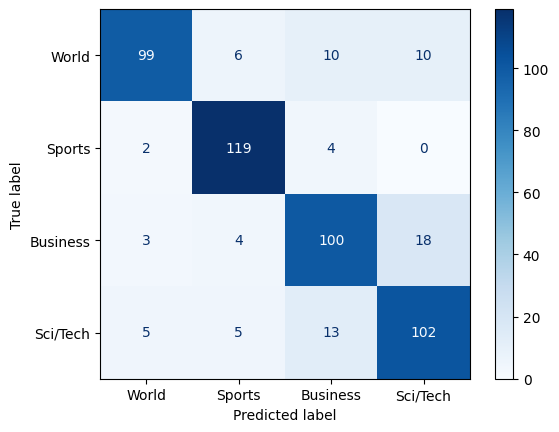

,World,Sports,Business,Sci/Tech,accuracy,macro avg,weighted avg
precision,0.908257,0.888060,0.787402,0.784615,0.84,0.842083,0.842083
recall,0.792000,0.952000,0.800000,0.816000,0.84,0.840000,0.840000
f1-score,0.846154,0.918919,0.793651,0.800000,0.84,0.839681,0.839681
support,125.000000,125.000000,125.000000,125.000000,0.84,500.000000,500.000000


In [11]:
model.load_state_dict(torch.load(CHECKPOINT_PATH))

test_loss, test_acc, test_f1, test_cm = evaluate(
    model, test_loader, criterion, DEVICE,
    save_path="results/w2v_test.csv")

### Train and Test the RNN:

In [12]:
rnn_train_dataset = RNN_Dataset(train_data, "checkpoints/word2vec.model",
                                SEQUENCE_LENGTH, OUTPUT_DIM)
rnn_val_dataset = RNN_Dataset(val_data, "checkpoints/word2vec.model",
                              SEQUENCE_LENGTH, OUTPUT_DIM)
rnn_test_dataset = RNN_Dataset(test, "checkpoints/word2vec.model",
                               SEQUENCE_LENGTH, OUTPUT_DIM)

CHECKPOINT_PATH = "checkpoints/rnn_model.pth"

train_loader = DataLoader(rnn_train_dataset,
                          batch_size=BATCH_SIZE,
                          pin_memory=True,
                          shuffle=True)
val_loader = DataLoader(rnn_val_dataset,
                        batch_size=BATCH_SIZE,
                        pin_memory=True,
                        shuffle=False)
test_loader = DataLoader(rnn_test_dataset,
                         batch_size=BATCH_SIZE,
                         pin_memory=True,
                         shuffle=False)

model = RNN_Model(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM).to(DEVICE)
criterion = nn.CrossEntropyLoss()

In [14]:
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                       factor=0.5, patience=5)


train(model, train_loader,
      val_loader, optimizer,
      scheduler, criterion,
      NUM_EPOCHS,
      CHECKPOINT_PATH,
      DEVICE)

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.001
Saving model with Val Loss: 0.8485

Epoch 1/50, Train Loss: 1.0055, Val Loss: 0.8485




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.001
Saving model with Val Loss: 0.7871

Epoch 2/50, Train Loss: 0.9319, Val Loss: 0.7871




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.001
Saving model with Val Loss: 0.7205

Epoch 3/50, Train Loss: 0.6340, Val Loss: 0.7205




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.001
Saving model with Val Loss: 0.6423

Epoch 4/50, Train Loss: 0.5319, Val Loss: 0.6423




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.001
Epoch 5/50, Train Loss: 0.5860, Val Loss: 0.6755




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.001
Epoch 6/50, Train Loss: 0.4775, Val Loss: 0.6601




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.001
Saving model with Val Loss: 0.5978

Epoch 7/50, Train Loss: 0.4438, Val Loss: 0.5978




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.001
Epoch 8/50, Train Loss: 0.4239, Val Loss: 0.6149




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.001
Epoch 9/50, Train Loss: 0.4131, Val Loss: 0.6859




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.001
Epoch 10/50, Train Loss: 0.3720, Val Loss: 0.6166




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.001
Epoch 11/50, Train Loss: 0.3537, Val Loss: 0.6368




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.001
Epoch 12/50, Train Loss: 0.3735, Val Loss: 0.7963




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.0005
Loading best model with Val Loss: 0.5978

Epoch 13/50, Train Loss: 0.3848, Val Loss: 0.7113




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.0005
Epoch 14/50, Train Loss: 0.3963, Val Loss: 0.6446




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.0005
Saving model with Val Loss: 0.5919

Epoch 15/50, Train Loss: 0.4005, Val Loss: 0.5919




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.0005
Epoch 16/50, Train Loss: 0.3893, Val Loss: 0.5931




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.0005
Saving model with Val Loss: 0.5852

Epoch 17/50, Train Loss: 0.3588, Val Loss: 0.5852




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.0005
Epoch 18/50, Train Loss: 0.3596, Val Loss: 0.6474




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.0005
Epoch 19/50, Train Loss: 0.3265, Val Loss: 0.6072




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.0005
Epoch 20/50, Train Loss: 0.3316, Val Loss: 0.6465




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.0005
Epoch 21/50, Train Loss: 0.3217, Val Loss: 0.7372




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.0005
Epoch 22/50, Train Loss: 0.3343, Val Loss: 0.6824




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.00025
Loading best model with Val Loss: 0.5852

Epoch 23/50, Train Loss: 0.3030, Val Loss: 0.6615




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.00025
Epoch 24/50, Train Loss: 0.3395, Val Loss: 0.6114




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.00025
Epoch 25/50, Train Loss: 0.3208, Val Loss: 0.6089




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.00025
Epoch 26/50, Train Loss: 0.3182, Val Loss: 0.5933




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.00025
Epoch 27/50, Train Loss: 0.3175, Val Loss: 0.6677




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.00025
Epoch 28/50, Train Loss: 0.3367, Val Loss: 0.6213




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.000125
Loading best model with Val Loss: 0.5852

Epoch 29/50, Train Loss: 0.3206, Val Loss: 0.6442




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.000125
Saving model with Val Loss: 0.5840

Epoch 30/50, Train Loss: 0.3333, Val Loss: 0.5840




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.000125
Epoch 31/50, Train Loss: 0.3266, Val Loss: 0.5907




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.000125
Epoch 32/50, Train Loss: 0.3256, Val Loss: 0.5884




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.000125
Epoch 33/50, Train Loss: 0.3147, Val Loss: 0.5865




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.000125
Saving model with Val Loss: 0.5833

Epoch 34/50, Train Loss: 0.3114, Val Loss: 0.5833




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.000125
Saving model with Val Loss: 0.5715

Epoch 35/50, Train Loss: 0.3034, Val Loss: 0.5715




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.000125
Epoch 36/50, Train Loss: 0.3134, Val Loss: 0.6041




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.000125
Epoch 37/50, Train Loss: 0.2990, Val Loss: 0.5998




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.000125
Epoch 38/50, Train Loss: 0.3003, Val Loss: 0.6161




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.000125
Epoch 39/50, Train Loss: 0.2967, Val Loss: 0.6111




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.000125
Epoch 40/50, Train Loss: 0.3007, Val Loss: 0.5967




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 6.25e-05
Loading best model with Val Loss: 0.5715

Epoch 41/50, Train Loss: 0.2838, Val Loss: 0.6245




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 6.25e-05
Epoch 42/50, Train Loss: 0.2962, Val Loss: 0.5877




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 6.25e-05
Epoch 43/50, Train Loss: 0.2989, Val Loss: 0.5870




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 6.25e-05
Epoch 44/50, Train Loss: 0.2953, Val Loss: 0.5940




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 6.25e-05
Epoch 45/50, Train Loss: 0.2924, Val Loss: 0.5909




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 6.25e-05
Epoch 46/50, Train Loss: 0.2910, Val Loss: 0.6070




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 3.125e-05
Loading best model with Val Loss: 0.5715

Epoch 47/50, Train Loss: 0.2921, Val Loss: 0.6208




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 3.125e-05
Epoch 48/50, Train Loss: 0.2956, Val Loss: 0.5879




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 3.125e-05
Epoch 49/50, Train Loss: 0.2981, Val Loss: 0.5847




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 3.125e-05
Epoch 50/50, Train Loss: 0.2944, Val Loss: 0.5858


Best Val Loss: 0.5715



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 0.5313

Test Accuracy: 81.8000%

Test F1 Score: 81.7398%



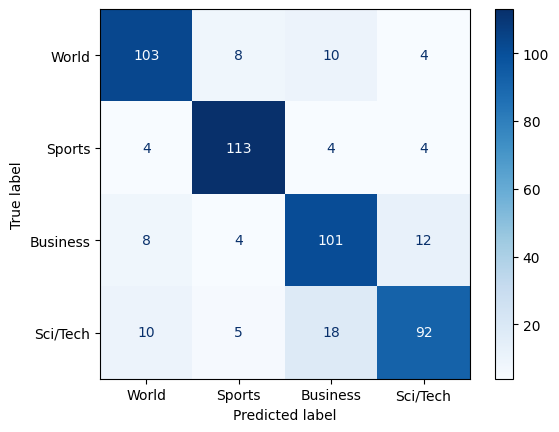

,World,Sports,Business,Sci/Tech,accuracy,macro avg,weighted avg
precision,0.824,0.869231,0.759398,0.821429,0.818,0.818514,0.818514
recall,0.824,0.904000,0.808000,0.736000,0.818,0.818000,0.818000
f1-score,0.824,0.886275,0.782946,0.776371,0.818,0.817398,0.817398
support,125.000,125.000000,125.000000,125.000000,0.818,500.000000,500.000000


In [13]:
model.load_state_dict(torch.load(CHECKPOINT_PATH))

test_loss, test_acc, test_f1, test_cm = evaluate(
    model, test_loader, criterion, DEVICE,
    save_path="results/rnn_test.csv")

### Train and Test the LSTM:

In [14]:
lstm_train_dataset = RNN_Dataset(train_data, "checkpoints/word2vec.model",
                                 SEQUENCE_LENGTH, OUTPUT_DIM)
lstm_val_dataset = RNN_Dataset(val_data, "checkpoints/word2vec.model",
                               SEQUENCE_LENGTH, OUTPUT_DIM)
lstm_test_dataset = RNN_Dataset(test, "checkpoints/word2vec.model",
                                SEQUENCE_LENGTH, OUTPUT_DIM)

CHECKPOINT_PATH = "checkpoints/lstm_model.pth"

train_loader = DataLoader(lstm_train_dataset,
                          batch_size=BATCH_SIZE,
                          pin_memory=True,
                          shuffle=True)
val_loader = DataLoader(lstm_val_dataset,
                        batch_size=BATCH_SIZE,
                        pin_memory=True,
                        shuffle=False)
test_loader = DataLoader(lstm_test_dataset,
                         batch_size=BATCH_SIZE,
                         pin_memory=True,
                         shuffle=False)

model = LSTM_Model(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM).to(DEVICE)
criterion = nn.CrossEntropyLoss()

In [17]:
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                       factor=0.5, patience=5)

train(model, train_loader,
      val_loader, optimizer,
      scheduler, criterion,
      NUM_EPOCHS,
      CHECKPOINT_PATH,
      DEVICE)

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.001
Saving model with Val Loss: 0.6424

Epoch 1/50, Train Loss: 0.7485, Val Loss: 0.6424




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.001
Saving model with Val Loss: 0.5378

Epoch 2/50, Train Loss: 0.4521, Val Loss: 0.5378




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.001
Epoch 3/50, Train Loss: 0.3813, Val Loss: 0.5744




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.001
Epoch 4/50, Train Loss: 0.3271, Val Loss: 0.5449




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.001
Epoch 5/50, Train Loss: 0.2682, Val Loss: 0.5431




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.001
Epoch 6/50, Train Loss: 0.2244, Val Loss: 0.5953




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.001
Epoch 7/50, Train Loss: 0.2083, Val Loss: 0.6661




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.0005
Loading best model with Val Loss: 0.5378

Epoch 8/50, Train Loss: 0.1946, Val Loss: 0.6088




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.0005
Epoch 9/50, Train Loss: 0.3538, Val Loss: 0.5481




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.0005
Epoch 10/50, Train Loss: 0.3072, Val Loss: 0.5434




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.0005
Epoch 11/50, Train Loss: 0.2804, Val Loss: 0.5559




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.0005
Epoch 12/50, Train Loss: 0.2605, Val Loss: 0.5931




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.0005
Epoch 13/50, Train Loss: 0.2087, Val Loss: 0.5936




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.00025
Loading best model with Val Loss: 0.5378

Epoch 14/50, Train Loss: 0.1991, Val Loss: 0.5889




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.00025
Saving model with Val Loss: 0.5336

Epoch 15/50, Train Loss: 0.3494, Val Loss: 0.5336




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.00025
Epoch 16/50, Train Loss: 0.3060, Val Loss: 0.5797




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.00025
Epoch 17/50, Train Loss: 0.2734, Val Loss: 0.6038




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.00025
Epoch 18/50, Train Loss: 0.2438, Val Loss: 0.5981




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.00025
Epoch 19/50, Train Loss: 0.2133, Val Loss: 0.5695




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.00025
Epoch 20/50, Train Loss: 0.1955, Val Loss: 1.3693




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.000125
Loading best model with Val Loss: 0.5336

Epoch 21/50, Train Loss: 0.1679, Val Loss: 0.6127




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.000125
Saving model with Val Loss: 0.5318

Epoch 22/50, Train Loss: 0.3210, Val Loss: 0.5318




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.000125
Epoch 23/50, Train Loss: 0.2915, Val Loss: 0.5397




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.000125
Epoch 24/50, Train Loss: 0.2675, Val Loss: 0.5663




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.000125
Epoch 25/50, Train Loss: 0.2494, Val Loss: 0.5623




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.000125
Epoch 26/50, Train Loss: 0.2336, Val Loss: 0.5728




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 0.000125
Epoch 27/50, Train Loss: 0.2071, Val Loss: 0.6047




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 6.25e-05
Loading best model with Val Loss: 0.5318

Epoch 28/50, Train Loss: 0.1886, Val Loss: 0.6056




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 6.25e-05
Saving model with Val Loss: 0.5313

Epoch 29/50, Train Loss: 0.2938, Val Loss: 0.5313




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 6.25e-05
Epoch 30/50, Train Loss: 0.2789, Val Loss: 0.5434




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 6.25e-05
Epoch 31/50, Train Loss: 0.2660, Val Loss: 0.5570




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 6.25e-05
Epoch 32/50, Train Loss: 0.2530, Val Loss: 0.5581




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 6.25e-05
Epoch 33/50, Train Loss: 0.2395, Val Loss: 0.5714




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 6.25e-05
Epoch 34/50, Train Loss: 0.2317, Val Loss: 0.5869




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 3.125e-05
Loading best model with Val Loss: 0.5313

Epoch 35/50, Train Loss: 0.2262, Val Loss: 0.5892




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 3.125e-05
Epoch 36/50, Train Loss: 0.2789, Val Loss: 0.5379




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 3.125e-05
Epoch 37/50, Train Loss: 0.2729, Val Loss: 0.5441




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 3.125e-05
Epoch 38/50, Train Loss: 0.2645, Val Loss: 0.5497




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 3.125e-05
Epoch 39/50, Train Loss: 0.2569, Val Loss: 0.5580




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 3.125e-05
Epoch 40/50, Train Loss: 0.2504, Val Loss: 0.5646




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 1.5625e-05
Loading best model with Val Loss: 0.5313

Epoch 41/50, Train Loss: 0.2410, Val Loss: 0.5683




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 1.5625e-05
Epoch 42/50, Train Loss: 0.2798, Val Loss: 0.5342




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 1.5625e-05
Epoch 43/50, Train Loss: 0.2761, Val Loss: 0.5385




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 1.5625e-05
Epoch 44/50, Train Loss: 0.2786, Val Loss: 0.5401




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 1.5625e-05
Epoch 45/50, Train Loss: 0.2678, Val Loss: 0.5449




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 1.5625e-05
Epoch 46/50, Train Loss: 0.2677, Val Loss: 0.5477




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 7.8125e-06
Loading best model with Val Loss: 0.5313

Epoch 47/50, Train Loss: 0.2685, Val Loss: 0.5508




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 7.8125e-06
Epoch 48/50, Train Loss: 0.2842, Val Loss: 0.5335




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 7.8125e-06
Epoch 49/50, Train Loss: 0.2758, Val Loss: 0.5360




Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Last LR: 7.8125e-06
Epoch 50/50, Train Loss: 0.2756, Val Loss: 0.5369


Best Val Loss: 0.5313



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 0.4884

Test Accuracy: 84.0000%

Test F1 Score: 84.0008%



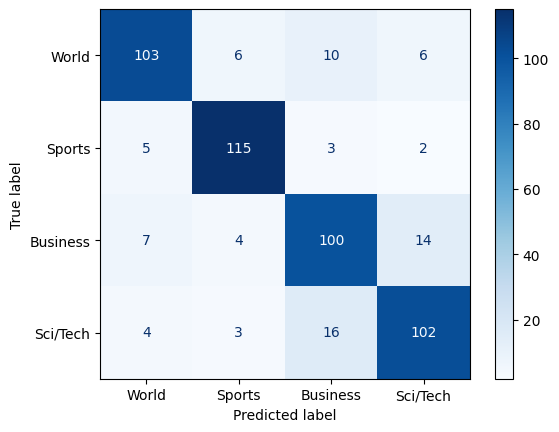

,World,Sports,Business,Sci/Tech,accuracy,macro avg,weighted avg
precision,0.865546,0.898438,0.775194,0.822581,0.84,0.840440,0.840440
recall,0.824000,0.920000,0.800000,0.816000,0.84,0.840000,0.840000
f1-score,0.844262,0.909091,0.787402,0.819277,0.84,0.840008,0.840008
support,125.000000,125.000000,125.000000,125.000000,0.84,500.000000,500.000000


In [15]:
model.load_state_dict(torch.load(CHECKPOINT_PATH))

test_loss, test_acc, test_f1, test_cm = evaluate(
    model, test_loader, criterion, DEVICE,
    save_path="results/lstm_test.csv")